In [1]:
import numpy as np
np.random.seed(10)
import tensorflow as tf
tf.random.set_seed(10)

In [2]:
from tensorflow import keras
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping

from tcn import TCN
import matplotlib.pyplot as plt

In [3]:
# Load data
raw_training_data = np.load('Time_Series_Training_Data.npy')
num_simulations = np.shape(raw_training_data)[0]
num_data_points = np.shape(raw_training_data)[0]*np.shape(raw_training_data)[1]
num_timesteps_per_simulation = np.shape(raw_training_data)[1]
state_len = np.shape(raw_training_data)[-1]

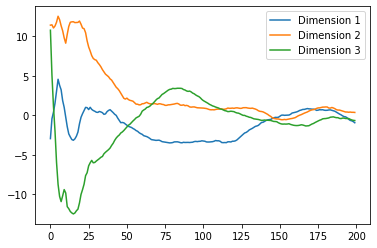

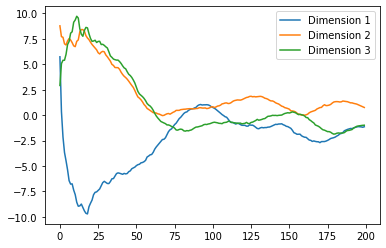

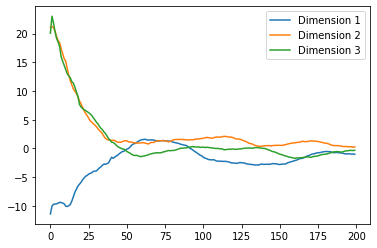

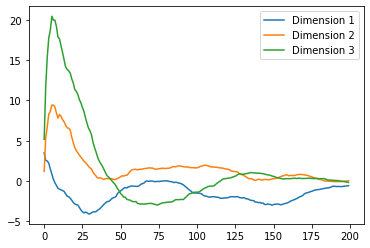

In [4]:
for sim_num in range(4):
    plt.plot(raw_training_data[sim_num,:,0],label='Dimension 1')
    plt.plot(raw_training_data[sim_num,:,1],label='Dimension 2')
    plt.plot(raw_training_data[sim_num,:,2],label='Dimension 3')
    plt.legend()
    plt.show()

In [5]:
# Load in data into windowed input and windowed output
input_window_length = 20
output_window_length = 1 # Must either be 1 or equal to input_window_length

if output_window_length != 1:
    
    training_data_ip = np.zeros(shape=(num_data_points-num_simulations*input_window_length*output_window_length,input_window_length,state_len))
    training_data_op = np.zeros(shape=(num_data_points-num_simulations*input_window_length*output_window_length,output_window_length,state_len-2))
    
    sim_num = 0
    sample = 0
    for t in range(np.shape(training_data_ip)[0]):
        training_data_ip[t,:,:] = raw_training_data[sim_num,sample:sample+input_window_length,:]
        training_data_op[t,:,:] = raw_training_data[sim_num,sample+input_window_length:sample+input_window_length+output_window_length,:-2]

        sample = sample + 1

        if sample == num_timesteps_per_simulation - input_window_length*output_window_length:
            sample = 0
            sim_num = sim_num + 1

    # Randomize
    idx = np.arange(np.shape(training_data_ip)[0])
    np.random.shuffle(idx)
    training_data_ip = training_data_ip[idx]
    training_data_op = training_data_op[idx]
else:
    training_data_ip = np.zeros(shape=(num_data_points-num_simulations*input_window_length*output_window_length,input_window_length,state_len))
    training_data_op = np.zeros(shape=(num_data_points-num_simulations*input_window_length*output_window_length,state_len-2))
    
    sim_num = 0
    sample = 0
    for t in range(np.shape(training_data_ip)[0]):
        training_data_ip[t,:,:] = raw_training_data[sim_num,sample:sample+input_window_length,:]
        training_data_op[t,:] = raw_training_data[sim_num,sample+input_window_length,:-2]

        sample = sample + 1

        if sample == num_timesteps_per_simulation - input_window_length*output_window_length:
            sample = 0
            sim_num = sim_num + 1

    # Randomize
    idx = np.arange(np.shape(training_data_ip)[0])
    np.random.shuffle(idx)
    training_data_ip = training_data_ip[idx]
    training_data_op = training_data_op[idx]

In [6]:
# Build TCN model
if output_window_length != 1:

    batch_size = None
    inputs = Input(batch_shape=(batch_size, input_window_length, state_len))
    tcn_output = TCN(return_sequences=True)(inputs)  # The TCN layers are here.
    output = Dense(state_len-2,activation='linear')(tcn_output)
    m = Model(inputs=[inputs], outputs=[output])
    m.compile(optimizer='adam', loss='mse')

    filepath = "tcn_weights.h5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min',save_weights_only=True)
    earlystopping = EarlyStopping(monitor='loss', min_delta=0, patience=10, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
    callbacks_list = [checkpoint,earlystopping]

    m.summary()
else:
    batch_size = None
    inputs = Input(batch_shape=(batch_size, input_window_length, state_len))
    tcn_output = TCN(return_sequences=False)(inputs)  # The TCN layers are here.
    output = Dense(state_len-2,activation='linear')(tcn_output)
    m = Model(inputs=[inputs], outputs=[output])
    m.compile(optimizer='adam', loss='mse')

    filepath = "tcn_weights.h5"
    checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min',save_weights_only=True)
    earlystopping = EarlyStopping(monitor='loss', min_delta=0, patience=10, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
    callbacks_list = [checkpoint,earlystopping]

    m.summary()
    

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 20, 14)]          0         
_________________________________________________________________
tcn (TCN)                    (None, 64)                93632     
_________________________________________________________________
dense (Dense)                (None, 12)                780       
Total params: 94,412
Trainable params: 94,412
Non-trainable params: 0
_________________________________________________________________


In [7]:
history = m.fit(training_data_ip, training_data_op, epochs=100, validation_split=0.1, callbacks=callbacks_list)

Epoch 1/100
51/51 [==============================] - ETA: 0s - loss: 73.2427
Epoch 00001: val_loss improved from inf to 6.13933, saving model to tcn_weights.h5
51/51 [==============================] - 1s 18ms/step - loss: 73.2427 - val_loss: 6.1393
Epoch 2/100
49/51 [===========================>..] - ETA: 0s - loss: 3.1548
Epoch 00002: val_loss improved from 6.13933 to 2.46080, saving model to tcn_weights.h5
51/51 [==============================] - 1s 15ms/step - loss: 3.1263 - val_loss: 2.4608
Epoch 3/100
48/51 [===========================>..] - ETA: 0s - loss: 1.6719
Epoch 00003: val_loss improved from 2.46080 to 1.62109, saving model to tcn_weights.h5
51/51 [==============================] - 1s 16ms/step - loss: 1.6549 - val_loss: 1.6211
Epoch 4/100
49/51 [===========================>..] - ETA: 0s - loss: 1.1245
Epoch 00004: val_loss improved from 1.62109 to 1.17115, saving model to tcn_weights.h5
51/51 [==============================] - 1s 15ms/step - loss: 1.1143 - val_loss: 1.171

Epoch 36/100
51/51 [==============================] - ETA: 0s - loss: 0.1589
Epoch 00036: val_loss did not improve from 0.16749
51/51 [==============================] - 1s 22ms/step - loss: 0.1589 - val_loss: 0.1883
Epoch 37/100
49/51 [===========================>..] - ETA: 0s - loss: 0.1461
Epoch 00037: val_loss did not improve from 0.16749
51/51 [==============================] - 1s 19ms/step - loss: 0.1470 - val_loss: 0.2273
Epoch 38/100
50/51 [============================>.] - ETA: 0s - loss: 0.1484
Epoch 00038: val_loss did not improve from 0.16749
51/51 [==============================] - 1s 18ms/step - loss: 0.1498 - val_loss: 0.1878
Epoch 39/100
48/51 [===========================>..] - ETA: 0s - loss: 0.1389
Epoch 00039: val_loss did not improve from 0.16749
51/51 [==============================] - 1s 19ms/step - loss: 0.1392 - val_loss: 0.2911
Epoch 40/100
49/51 [===========================>..] - ETA: 0s - loss: 0.1423
Epoch 00040: val_loss did not improve from 0.16749
51/51 [=

## A priori prediction quality on training data

In [8]:
m.load_weights(filepath)

if output_window_length != 1:
    sim_num = 0
    pred_seq = np.copy(raw_training_data[sim_num:sim_num+1,:,:])
    for t in range(0,num_timesteps_per_simulation-input_window_length*output_window_length,input_window_length):
        input_seq = raw_training_data[sim_num:sim_num+1,t:t+input_window_length,:]
        pred_seq[0,t+input_window_length:t+input_window_length+output_window_length,:state_len-2] = m.predict(input_seq)     
else:
    sim_num = 0
    pred_seq = np.copy(raw_training_data[sim_num:sim_num+1,:,:])
    for t in range(0,num_timesteps_per_simulation-input_window_length*output_window_length):
        input_seq = raw_training_data[sim_num:sim_num+1,t:t+input_window_length,:]
        pred_seq[0,t+input_window_length,:state_len-2] = m.predict(input_seq)      

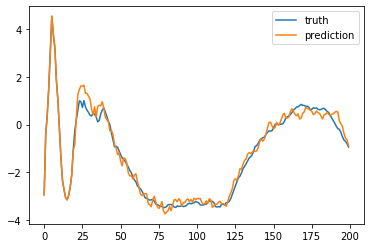

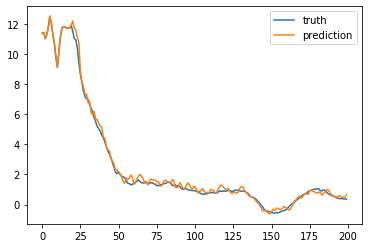

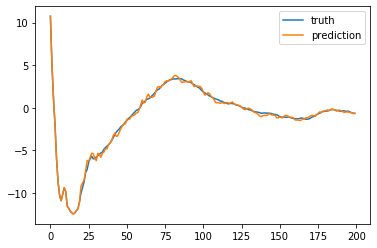

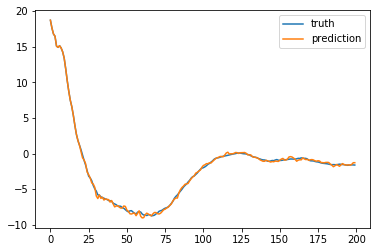

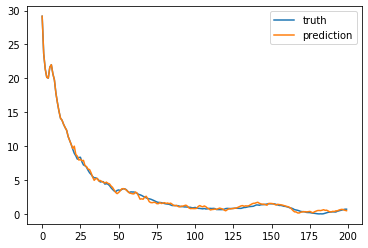

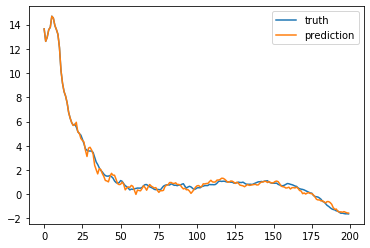

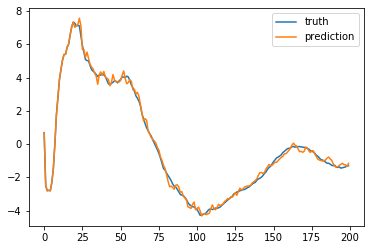

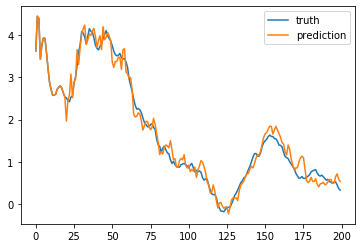

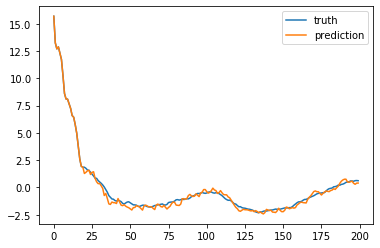

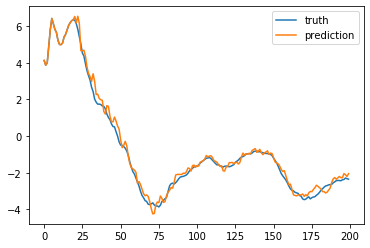

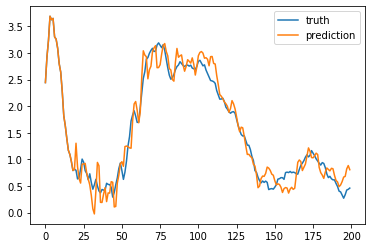

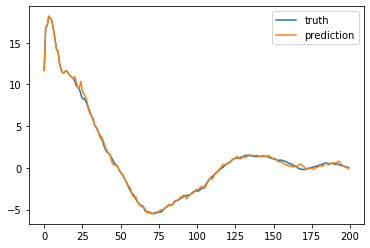

In [9]:
for mode in range(12):
    plt.figure()
    plt.plot(raw_training_data[sim_num,:,mode],label='truth')
    plt.plot(pred_seq[0,:,mode],label='prediction')
    plt.legend()
    plt.show()

## A posteriori prediction quality on training data

In [10]:
if output_window_length != 1:
    sim_num = 0
    pred_seq = np.copy(raw_training_data[sim_num:sim_num+1,:,:])
    for t in range(0,num_timesteps_per_simulation-input_window_length*output_window_length,input_window_length):
        input_seq = pred_seq[0:1,t:t+input_window_length,:]
        pred_seq[0,t+input_window_length:t+input_window_length+output_window_length,:state_len-2] = m.predict(input_seq)     
else:
    sim_num = 0
    pred_seq = np.copy(raw_training_data[sim_num:sim_num+1,:,:])
    for t in range(0,num_timesteps_per_simulation-input_window_length*output_window_length):
        input_seq = pred_seq[0:1,t:t+input_window_length,:]
        pred_seq[0,t+input_window_length,:state_len-2] = m.predict(input_seq)      

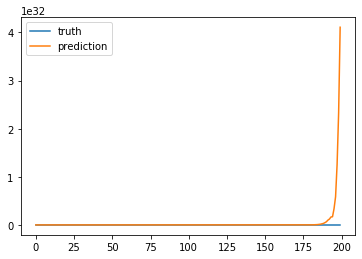

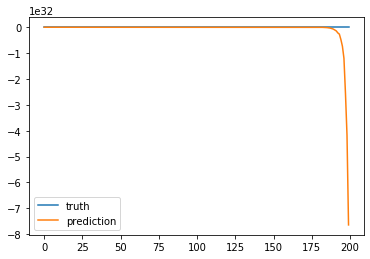

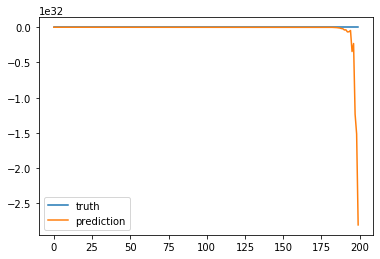

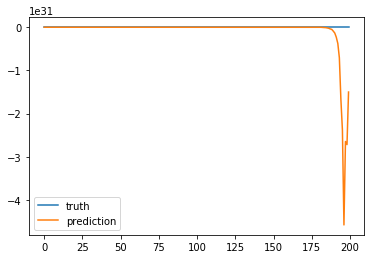

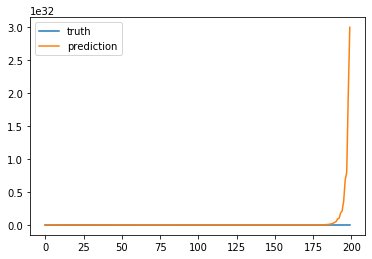

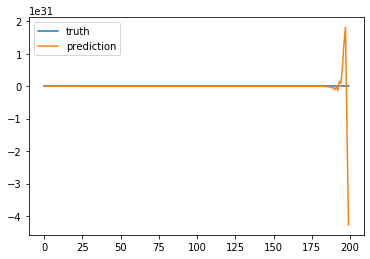

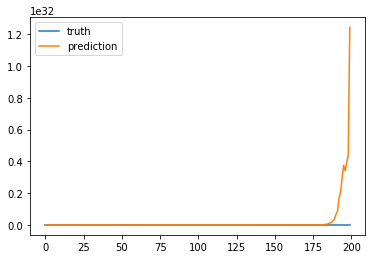

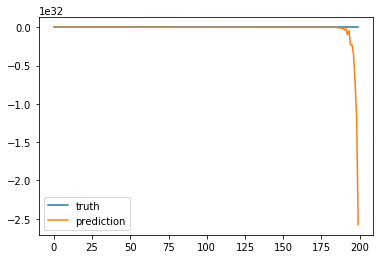

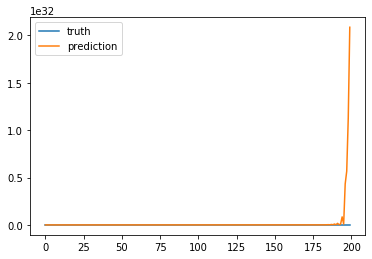

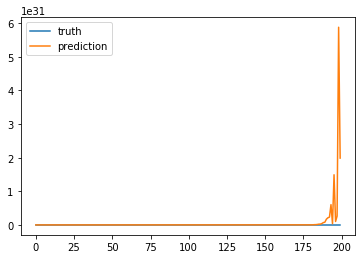

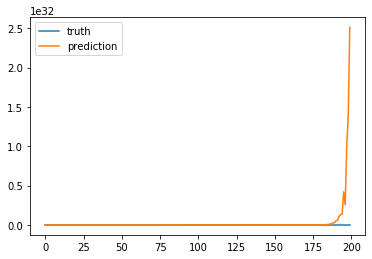

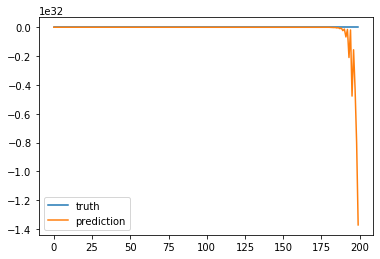

In [11]:
for mode in range(12):
    plt.figure()
    plt.plot(raw_training_data[sim_num,:,mode],label='truth')
    plt.plot(pred_seq[0,:,mode],label='prediction')
    plt.legend()
    plt.show()

## Testing - A priori

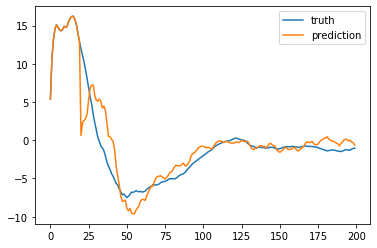

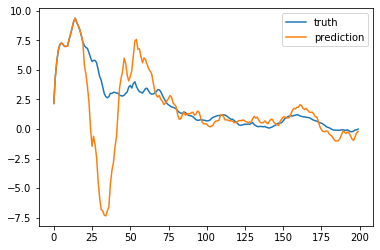

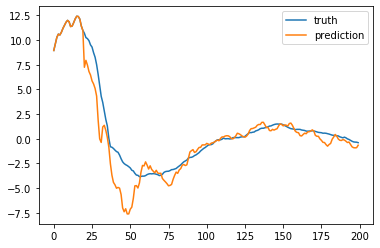

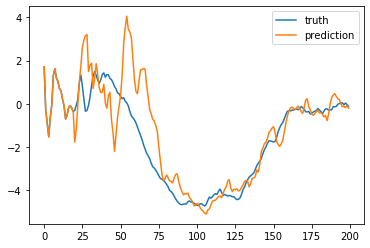

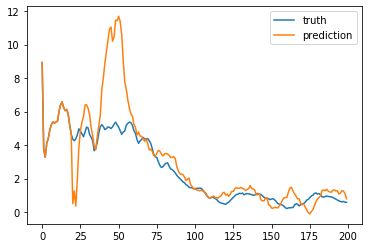

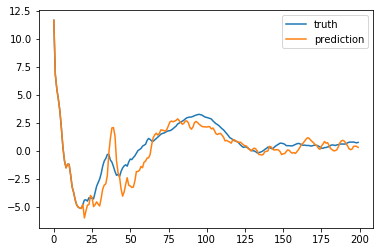

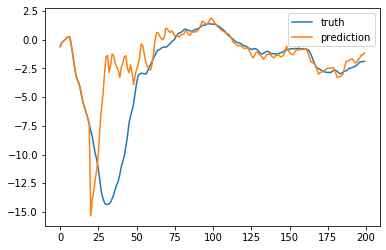

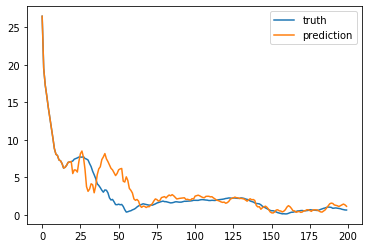

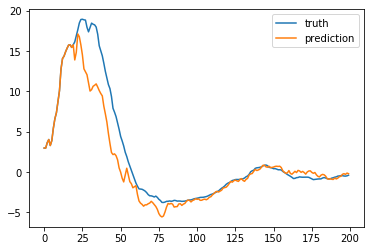

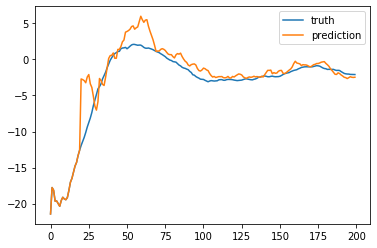

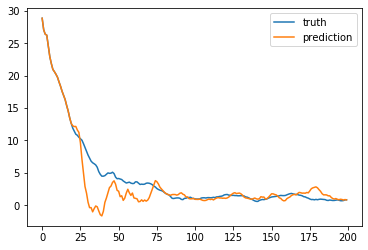

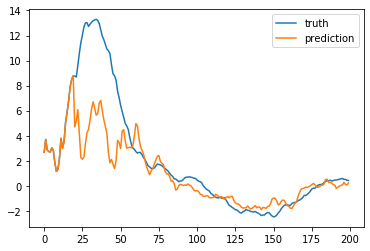

In [12]:
raw_testing_data = np.load('Time_Series_Testing_Data.npy')
num_test_simulations = np.shape(raw_testing_data)[0]
num_timesteps_test = np.shape(raw_testing_data)[1]

if output_window_length != 1:
    sim_num = 0
    pred_seq = np.copy(raw_testing_data[sim_num:sim_num+1,:,:])
    for t in range(0,num_timesteps_test-input_window_length*output_window_length,input_window_length):
        input_seq = raw_testing_data[sim_num:sim_num+1,t:t+input_window_length,:]
        pred_seq[0,t+input_window_length:t+input_window_length+output_window_length,:state_len-2] = m.predict(input_seq)     
else:
    sim_num = 0
    pred_seq = np.copy(raw_testing_data[sim_num:sim_num+1,:,:])
    for t in range(0,num_timesteps_test-input_window_length*output_window_length):
        input_seq = raw_testing_data[sim_num:sim_num+1,t:t+input_window_length,:]
        pred_seq[0,t+input_window_length,:state_len-2] = m.predict(input_seq)
        
        
for mode in range(12):
    plt.figure()
    plt.plot(raw_testing_data[sim_num,:,mode],label='truth')
    plt.plot(pred_seq[0,:,mode],label='prediction')
    plt.legend()
    plt.show()

## Testing - A posteriori

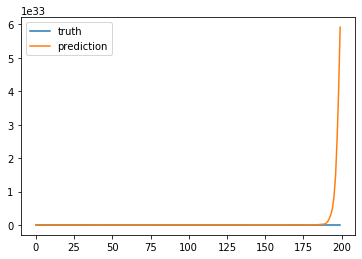

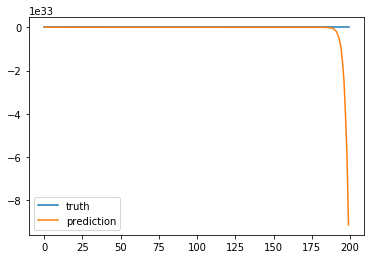

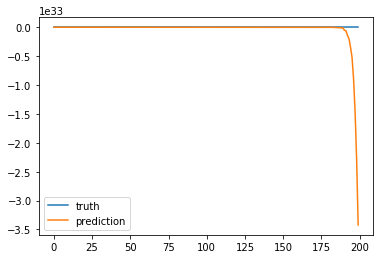

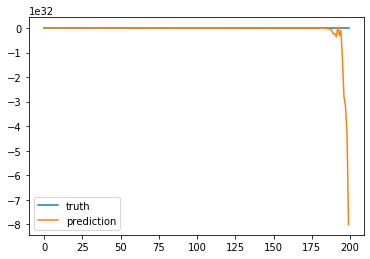

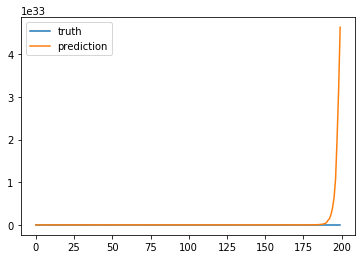

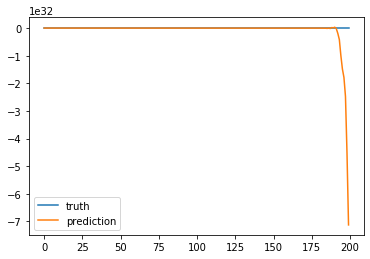

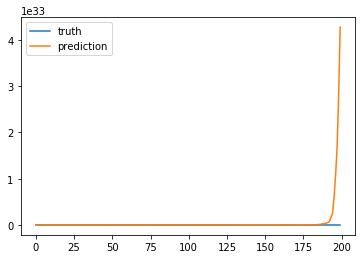

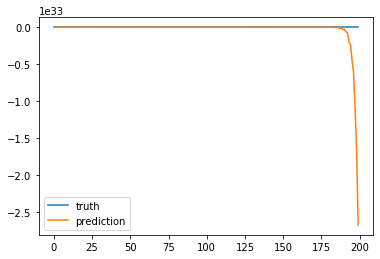

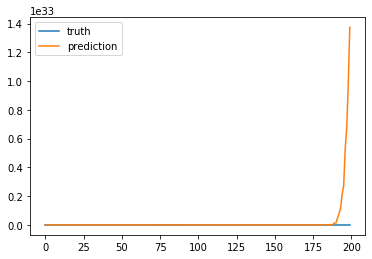

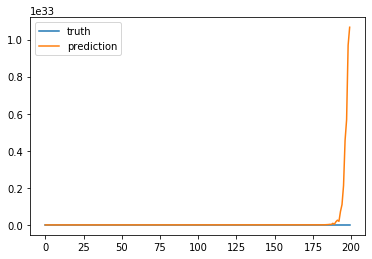

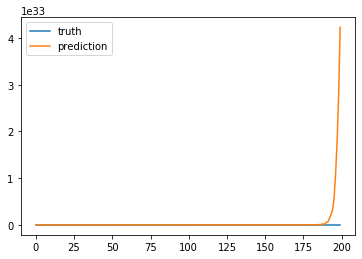

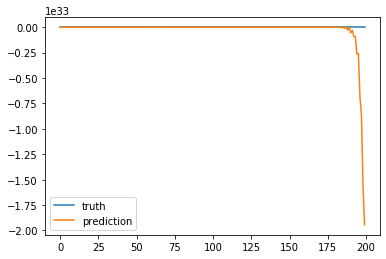

In [13]:
if output_window_length != 1:
    sim_num = 0
    pred_seq = np.copy(raw_testing_data[sim_num:sim_num+1,:,:])
    for t in range(0,num_timesteps_test-input_window_length*output_window_length,input_window_length):
        input_seq = pred_seq[0:1,t:t+input_window_length,:]
        pred_seq[0,t+input_window_length:t+input_window_length+output_window_length,:state_len-2] = m.predict(input_seq)     
else:
    sim_num = 0
    pred_seq = np.copy(raw_testing_data[sim_num:sim_num+1,:,:])
    for t in range(0,num_timesteps_test-input_window_length*output_window_length):
        input_seq = pred_seq[0:1,t:t+input_window_length,:]
        pred_seq[0,t+input_window_length,:state_len-2] = m.predict(input_seq)
        
        
for mode in range(12):
    plt.figure()
    plt.plot(raw_testing_data[sim_num,:,mode],label='truth')
    plt.plot(pred_seq[0,:,mode],label='prediction')
    plt.legend()
    plt.show()